# Can we predict tomorrow's electricity price? Random Forrest Model

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime as dt
import seaborn as sns

from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score

In [31]:
# Import data
df = pd.read_csv('../data/df_clean.csv', index_col=0, parse_dates=True)

# Copy actual price to new series
tomorrow = df['price actual'].copy()

# Shift the actual price index by a single day backwards
tomorrow = tomorrow.shift(-1, freq='D')

# Copy the df and merge tomorrows price into each row

df = df.join(tomorrow, how='inner', rsuffix='_tomorrow')
df.rename(columns={'price actual_tomorrow':'price tomorrow'}, inplace=True)

df_weather = df.dropna().copy()

## Random Forrest with Weather

In [22]:
X = df_weather.drop(columns = 'price tomorrow')
y = df_weather['price tomorrow'].copy()

In [20]:
# Fit RF model
def fit_train(x, y):
    rf = RandomForestRegressor()
    if len(x.shape)==1:
        x = x.to_numpy().reshape(-1,1)
    rf.fit(x,y)
    preds = rf.predict(x)
    results = pd.DataFrame({'pred':preds, 'true':y})
    print('r2: ',(results.corr()**2).iloc[0,1])
    return rf

### rf_1

In [23]:
# Train model and show results
rf_1 = fit_train(X, y)

r2:  0.9820846669785955


In [25]:
# See feature importances
results = pd.DataFrame({'features':X.columns, 'importance':rf_1.feature_importances_})
results.sort_values(by='importance', ascending=False).head()

,features,importance
19,price actual,0.692992
18,price day ahead,0.012929
4,generation fossil oil,0.010647
8,generation nuclear,0.010318
3,generation fossil hard coal,0.009850


<u>Notes</u>: R2 is very high actually. Seems as though price of the day before is by far the most important feature. Since price tomorrow is just price actual shifted by one day, lets remove it and see if the model still performs okay.
### rf_2

In [26]:
# Split data and target
X = df_weather.drop(columns = ['price tomorrow', 'price actual'])
rf_2 = fit_train(X, y)

r2:  0.9824072519283841


In [27]:
# See feature importances
results = pd.DataFrame({'features':X.columns, 'importance':rf_2.feature_importances_})
results.sort_values(by='importance', ascending=False).head()

,features,importance
18,price day ahead,0.408299
42,pressure_Bilbao,0.029109
8,generation nuclear,0.028649
6,generation hydro run-of-river and poundage,0.024591
15,forecast wind onshore day ahead,0.024293


<u>Notes</u>: The model still performed very well even without `price actual` which is great. Now `price day ahead` is clearly the most important feature which makes sense as it's the forecast for tomorrows price.  Is it possible that our other variables aren't even helping that much? Let's check by running a model with the `price day ahead` as the only variable and see how well the model can predict price.
#### rf_3

In [29]:
# Split data and target
X = df_weather.loc[:,'price day ahead']

rf_3 = fit_train(X, y)

r2:  0.5280599676256542


<u>Notes</u>: The model r2 decreased drastically, meaning that the other variables were actually important in predicting the price for tomorrow.  Up to this point, I have not split the data into testing and training.  Let's do that next and see if the model can generalize to unseen data.  I'll split out one continous year's worth of data and try to predict the missing year.  For the predictors, I'll continue to use all columns except for the `price actual` column.
#### rf_4

In [32]:
df_weather.drop(columns='price actual', inplace=True)

In [33]:
# Fit RF model
def fit_train(x_train, x_test, y_train, y_test):
    rf = RandomForestRegressor(random_state=17)
    if len(x_train.shape)==1:
        x_train = x_train.to_numpy().reshape(-1,1)
        x_test = x_test.to_numpy().reshape(-1,1)
    rf.fit(x_train,y_train)
    preds_train = rf.predict(x_train)
    preds_test = rf.predict(x_test)
    results_train = pd.DataFrame({'pred':preds_train, 'true':y_train})
    results_test = pd.DataFrame({'pred':preds_test, 'true':y_test})
    print('r2_train: ',(results_train.corr()**2).iloc[0,1])
    print('r2_test: ',(results_test.corr()**2).iloc[0,1])
    return rf

In [46]:
# Split data and target
X_train = df_weather.loc['2015':'2017'].drop(columns='price day ahead')
X_test  = df_weather.loc['2018'].drop(columns='price day ahead')

y_train = df_weather.loc['2015':'2017','price tomorrow']
y_test = df_weather.loc['2018','price tomorrow']

rf_4 = fit_train(X_train, X_test, y_train, y_test)

r2_train:  0.9999984813203489
r2_test:  0.9999996875698951


<u>Notes</u>: The model r2 is very very high. Let's remove all features except `price day ahead` to make sure the other features are important.
#### rf_5

In [35]:
# Split data and target
X_train = df_weather.loc['2015':'2017', 'price day ahead']
X_test  = df_weather.loc['2018', 'price day ahead']

y_train = df_weather.loc['2015':'2017','price tomorrow']
y_test = df_weather.loc['2018','price tomorrow']

rf_5 = fit_train(X_train, X_test, y_train, y_test)

r2_train:  0.5378585780152443
r2_test:  0.18852230471236708


In [26]:
OLD rf_5

r2_train:  0.9796928115385211
r2_test:  0.24724548570986396


<u>Notes</u>: Model r2 decreased substaintially on the testing set, which was to be expected since we only used `price day ahead` in this model. Next let's split the data randomly instead of testing on a continuous year.
#### rf_6

In [38]:
# train test split the data and rerun 
X_train, X_test, y_train, y_test = train_test_split(df_weather.drop(columns='price day ahead'), 
                                                    df_weather['price tomorrow'],
                                                    test_size=.25, 
                                                    random_state=17)

rf_6 = fit_train(X_train, X_test, y_train, y_test)

r2_train:  0.9999976526245771
r2_test:  0.9999914911149841


In [27]:
old rf_6

r2_train:  0.9805822563248657
r2_test:  0.8239157439853783


<u>Notes</u>: Model r2 is very good.  Let's try again but only use `price day ahead`. 
#### rf_7

In [39]:
# train test split the data and rerun 
X_train, X_test, y_train, y_test = train_test_split(df_weather['price day ahead'], 
                                                    df_weather['price tomorrow'],
                                                    test_size=.25, 
                                                    random_state=17)

rf_7 = fit_train(X_train, X_test, y_train, y_test)

r2_train:  0.5550053011989637
r2_test:  0.3152489759033701


In [28]:
OLD rf_7

r2_train:  0.5462970180903489
r2_test:  0.3265396852844339


#### Why does splitting out the year 2018 do so poorly?

In [ ]:
rf_4 = all cols, split 2018
rf_5 = price day ahead only, split 2018
rf_6 = all cols, random split
rf_7 = price day ahead only, random split

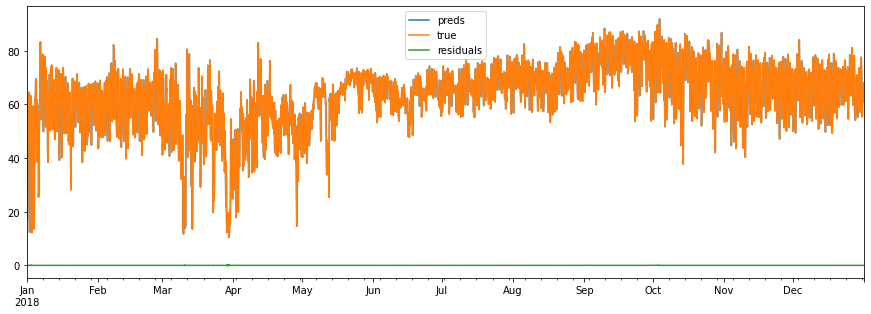

In [58]:
X_train = df_weather.loc['2015':'2017'].drop(columns='price day ahead')
X_test  = df_weather.loc['2018'].drop(columns='price day ahead')

y_train = df_weather.loc['2015':'2017','price tomorrow']
y_test = df_weather.loc['2018','price tomorrow']

start = dt.datetime(2018, 1, 1)
stop = dt.datetime(2018, 12, 31, 23)
rf4_results = pd.DataFrame({'preds':rf_4.predict(X_test), 
                            'true':y_test}, 
                           index=pd.date_range(start, stop, freq='H')
                           )
rf4_results['residuals'] = rf4_results.true - rf4_results.preds
rf4_results.plot(figsize=(15,5));

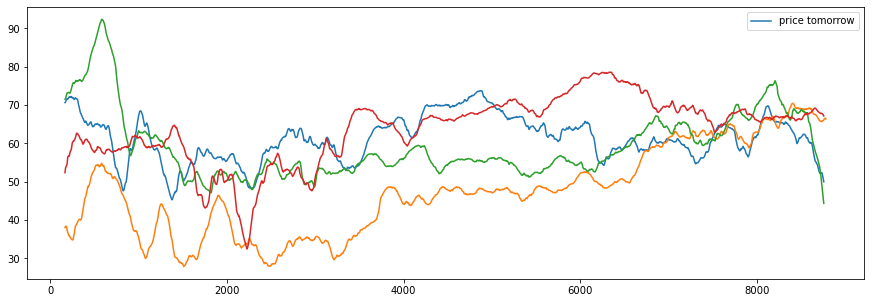

In [59]:
df_weather['price tomorrow'].loc['2015'].reset_index()['price tomorrow'].rolling(window=168).mean().plot(figsize=(15,5))
df_weather['price tomorrow'].loc['2016'].reset_index()['price tomorrow'].rolling(window=168).mean().plot(figsize=(15,5))
df_weather['price tomorrow'].loc['2017'].reset_index()['price tomorrow'].rolling(window=168).mean().plot(figsize=(15,5), legend=True)
df_weather['price tomorrow'].loc['2018'].reset_index()['price tomorrow'].rolling(window=168).mean().plot(figsize=(15,5));

In [60]:
results = pd.DataFrame({'features':X_train.columns, 'importance':rf_4.feature_importances_})
results.sort_values(by='importance', ascending=False).head(20)

,features,importance
76,price tomorrow,9.999897e-01
19,diff,1.103654e-06
11,generation solar,9.665699e-07
15,forecast wind onshore day ahead,5.427651e-07
53,wind_speed_Madrid,4.098092e-07
9,generation other,3.987496e-07
70,generation_scheduled,3.797870e-07
4,generation fossil oil,3.694020e-07
75,transmission_sf,3.253684e-07
60,temp_Valencia,2.851397e-07


In [61]:
resid_2015 = df_weather.loc['2015', 'price day ahead'] - df_weather.loc['2015', 'price tomorrow']
resid_2016 = df_weather.loc['2016', 'price day ahead'] - df_weather.loc['2016', 'price tomorrow']
resid_2017 = df_weather.loc['2017', 'price day ahead'] - df_weather.loc['2017', 'price tomorrow']
resid_2018 = df_weather.loc['2018', 'price day ahead'] - df_weather.loc['2018', 'price tomorrow']
print(resid_2015.mean())
print(resid_2016.mean())
print(resid_2017.mean())
print(resid_2018.mean())

-10.978213470319584
-7.8245286885245875
-6.9789440639269325
-6.261739726027396


In [63]:
(df_weather.corr()>.5).sum().sort_values(ascending=False).head(20)

generation fossil gas                   6
total load forecast                     6
temp_Seville                            5
temp_ Barcelona                         5
price day ahead                         5
total load actual                       5
temp_Valencia                           5
temp_Madrid                             5
temp_Bilbao                             5
generation fossil brown coal/lignite    4
generation fossil hard coal             4
generation total                        4
generation_scheduled                    4
humidity_ Barcelona                     2
generation biomass                      2
humidity_Seville                        2
humidity_Madrid                         2
pressure_Valencia                       2
humidity_Valencia                       2
consumption_scheduled                   2
dtype: int64

In [64]:
df_weather.corr()['generation fossil gas'].sort_values(ascending=False).head(10)

generation fossil gas                   1.000000
price day ahead                         0.640941
total load actual                       0.549000
total load forecast                     0.543792
generation fossil hard coal             0.542379
generation fossil brown coal/lignite    0.500410
generation total                        0.454143
generation_scheduled                    0.453185
price tomorrow                          0.376294
generation other renewable              0.336596
Name: generation fossil gas, dtype: float64

In [65]:
df_weather.corr()['temp_ Barcelona'].sort_values(ascending=False).head(10)

temp_ Barcelona             1.000000
temp_Valencia               0.917515
temp_Madrid                 0.903999
temp_Bilbao                 0.866736
temp_Seville                0.841916
forecast solar day ahead    0.391631
generation solar            0.386561
wind_deg_Seville            0.208402
diff                        0.191430
total load actual           0.167296
Name: temp_ Barcelona, dtype: float64

In [66]:
df_weather.corr()['price day ahead'].sort_values(ascending=False).head(10)

price day ahead                         1.000000
generation fossil hard coal             0.672286
generation fossil gas                   0.640941
price tomorrow                          0.623742
generation fossil brown coal/lignite    0.568483
total load forecast                     0.474786
total load actual                       0.474458
diff                                    0.434762
generation other renewable              0.429283
generation waste                        0.369069
Name: price day ahead, dtype: float64

#### Each year to predict the others 2015, 2016, 2017

In [102]:
# Split data and target
X_train = df_weather.loc['2015':'2017'].drop(columns='price day ahead')
X_test  = df_weather.loc['2018'].drop(columns='price day ahead')

y_train = df_weather.loc['2015':'2017','price tomorrow']
y_test = df_weather.loc['2018','price tomorrow']

rf_4 = fit_train(X_train, X_test, y_train, y_test)

In [103]:
df_3 = df_2.loc[:,cols].copy()

In [105]:
# train test split the data and rerun 
x_train, x_test, y_train, y_test = train_test_split(df_3.loc[:,:'transmission_sf'].drop(columns='price actual'), 
                                                    df_3['price tomorrow'],
                                                    test_size=.2, 
                                                    random_state=17)

rf_8 = fit_train(x_train, x_test, y_train, y_test)

r2_train:  0.9764353201781485
r2_test:  0.7782548846422505


## Predict 2015 based on 2016-18

In [73]:
# Split data and target
X_train = df_weather.loc['2016':'2018'].drop(columns='price day ahead')
X_test  = df_weather.loc['2015'].drop(columns='price day ahead')

y_train = df_weather.loc['2016':'2018','price tomorrow']
y_test = df_weather.loc['2015','price tomorrow']

rf_8 = fit_train(X_train, X_test, y_train, y_test)

r2_train:  0.9999986307383766
r2_test:  0.9999996150294732


## Predict 2016 based on 2015, 2017-18

In [80]:
# Split data and target
X_train = df_weather.loc['2015' and '2017':].drop(columns='price day ahead')
X_test  = df_weather.loc['2016'].drop(columns='price day ahead')

y_train = df_weather.loc['2015' and '2017':,'price tomorrow']
y_test = df_weather.loc['2016', 'price tomorrow']

rf_9 = fit_train(X_train, X_test, y_train, y_test)

r2_train:  0.9999968190982327
r2_test:  0.9999819954780711


In [126]:
OLD

r2_train:  0.9821400983041421
r2_test:  0.2317754666017054


## Predict 2017 based on 2015-16, 2018

In [81]:
# Split data and target
X_train = df_weather.loc[:'2016' and '2018'].drop(columns='price day ahead')
X_test  = df_weather.loc['2017'].drop(columns='price day ahead')

y_train = df_weather.loc[:'2015' and '2018','price tomorrow']
y_test = df_weather.loc['2017', 'price tomorrow']

rf_9 = fit_train(X_train, X_test, y_train, y_test)

r2_train:  0.9999989850175339
r2_test:  0.9999948255485296


In [127]:
OLD

r2_train:  0.9827180491196578
r2_test:  0.9796518362042905


# Random Forrest without Weather

In [96]:
X = df.loc[:,:'diff'].join(df.loc[:,'generation_scheduled':'transmission_sf'])
y = df.loc[:,'price tomorrow']

In [102]:
# Split data and target
X_train = X.loc[:'2020', :].drop(columns='price day ahead')
X_test  = X.loc['2021', :].drop(columns='price day ahead')

y_train = y.loc[:'2020']
y_test = y.loc['2021']

rf_10 = fit_train(X_train, X_test, y_train, y_test)

r2_train:  0.9853288966135381
r2_test:  0.4983591917811668


In [104]:
# Split data and target
X_train = X.loc[:'2020', :]
X_test  = X.loc['2021', :]

y_train = y.loc[:'2020']
y_test = y.loc['2021']

rf_11 = fit_train(X_train, X_test, y_train, y_test)

r2_train:  0.9853484739851249
r2_test:  0.4942581451735512
